In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/data/home/marmot/camtrap/PyCharm/CameraTraps-benchmark')

In [3]:
import json
import os
from collections import OrderedDict, defaultdict, Counter
from copy import deepcopy
from random import sample

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from data_management.cct_json_utils import CameraTrapJsonUtils, IndexedJsonDb
from visualization.visualization_utils import plot_stacked_bar_chart

## Species distribution

In [81]:
def show_species_dist(file_template, plot_title='', ordered_species_list=None, log_scale=False):
    
    # combine train and val splits for the image databases
    all_images = []
    all_annotations = []

    for i in ('train', 'val'):
        with open(file_template.format(i)) as f:
            db = json.load(f)
        print('{} has {} images, {} annotations'.format(i, len(db['images']), len(db['annotations'])))
        all_images.extend(db['images'])
        all_annotations.extend(db['annotations'])

    print('In total there are {} images, {} annotations'.format(len(all_images), len(all_annotations)))
    
    db_indexed = IndexedJsonDb(db)  # assume both train and val have the same categories field

    # get species by location
    
    image_to_loc = {}
    loc_to_species = defaultdict(Counter)

    for i in all_images:
        image_to_loc[i['id']] = i['location']

    for a in all_annotations:
        cat_name = db_indexed.cat_id_to_name[a['category_id']]
        loc = image_to_loc[a['image_id']]
        loc_to_species[loc].update([cat_name])
    
    all_species = set()
    for v in loc_to_species.values():
        for k in v.keys():
            all_species.add(k)
            
    print('\nThere are {} species:'.format(len(all_species)))
    print(all_species)
    
    if not ordered_species_list:
        ordered_species_list = []
    
    # get the series labels (the species)
    if len(ordered_species_list) < 20:
        for s in sorted(list(all_species)):
            if s not in ordered_species_list:
                ordered_species_list.append(s)
    print('\nordered_species_list of {} items:'.format(len(ordered_species_list)))
    print(ordered_species_list)
    
    loc_to_species_sorted = sorted(loc_to_species.items(), key=lambda x: sum(x[1].values()), reverse=True)

#     print('')
#     for index, item in enumerate(loc_to_species_sorted):
#         print(index, item)  # the same content as the plot
        
    series_labels = ordered_species_list
    col_labels = [x[0] for x in loc_to_species_sorted] # locations are the key in loc_to_species_sorted
    
    species_data = []
    for s in series_labels:
        s_across_locs = []
        for loc, counter in loc_to_species_sorted:
            s_across_locs.append(counter[s])
        species_data.append(s_across_locs)
    
    fig = plot_stacked_bar_chart(species_data, series_labels, col_labels=col_labels, 
                             x_label='Location ID', 
                             y_label='Number of images', log_scale=log_scale)

    fig.suptitle(plot_title)
    
    return fig

### Species distribution - CCT

train has 32865 images, 32873 annotations
val has 25000 images, 25070 annotations
In total there are 57865 images, 57943 annotations

There are 17 species:
{'deer', 'bobcat', 'skunk', 'empty', 'dog', 'rabbit', 'squirrel', 'opossum', 'rodent', 'car', 'badger', 'fox', 'bird', 'unlabeled_animal', 'raccoon', 'cat', 'coyote'}

ordered_species_list of 17 items:
['empty', 'unlabeled_animal', 'car', 'badger', 'bird', 'bobcat', 'cat', 'coyote', 'deer', 'dog', 'fox', 'opossum', 'rabbit', 'raccoon', 'rodent', 'skunk', 'squirrel']


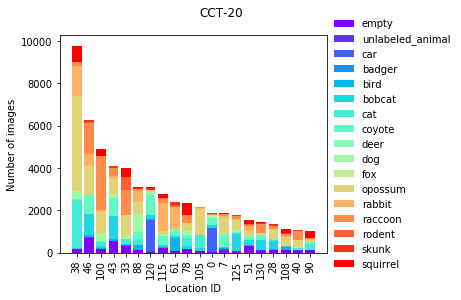

In [83]:
file_template = '/beaver_disk/camtrap/caltech/benchmark/cct-20/CaltechCameraTraps-20_v2.1_{}.json'
ordered_species = ['empty', 'unlabeled_animal', 'car']  # if you want to control the first few species
plot_title = 'CCT-20'

fig = show_species_dist(file_template, plot_title=plot_title, ordered_species_list=ordered_species)

### Species distribution - SS season 1

49 species is too many to show. Show top 20 instead

In [88]:
ss_file_template = '/beaver_disk/camtrap/ss_season1/benchmark/SnapshotSerengetiS01_{}.json'

In [89]:
# get the most populous species
ss_s1_all_annotations = []

for i in ('train', 'val'):
    with open(ss_file_template.format(i)) as f:
        db = json.load(f)
    print('{} has {} images, {} annotations'.format(i, len(db['images']), len(db['annotations'])))
    ss_s1_all_annotations.extend(db['annotations'])

db_indexed = IndexedJsonDb(db) # assume same categories in train and val
    
species_counter = Counter()
for a in ss_s1_all_annotations:
    cat_name = db_indexed.cat_id_to_name[a['category_id']]
    species_counter.update([cat_name])

species_counter_sorted = sorted(species_counter.items(), key=lambda x: x[1], reverse=True)

train has 314591 images, 315605 annotations
val has 96823 images, 97253 annotations


In [95]:
species_counter_sorted_no_reverse = sorted(species_counter.items(), key=lambda x: x[1])

In [99]:
species_counter_sorted_no_reverse[-20:]

top_20 = [i[0] for i in species_counter_sorted_no_reverse[-20:]]

[('koribustard', 591),
 ('lionmale', 665),
 ('wildebeest', 689),
 ('impala', 691),
 ('dikdik', 728),
 ('reedbuck', 946),
 ('buffalo', 1455),
 ('lionfemale', 1519),
 ('elephant', 1687),
 ('giraffe', 1923),
 ('hartebeest', 2139),
 ('otherbird', 2322),
 ('warthog', 2685),
 ('hyenaspotted', 2752),
 ('guineafowl', 3217),
 ('human', 4802),
 ('gazellegrants', 4967),
 ('zebra', 5592),
 ('gazellethomsons', 29705),
 ('empty', 338837)]

train has 314591 images, 315605 annotations
val has 96823 images, 97253 annotations
In total there are 411414 images, 412858 annotations

There are 49 species:
{'genet', 'honeybadger', 'guineafowl', 'ostrich', 'lionmale', 'monkeyvervet', 'buffalo', 'hyenastriped', 'civet', 'hare', 'lionfemale', 'reptiles', 'wildebeest', 'caracal', 'hartebeest', 'secretarybird', 'empty', 'koribustard', 'rhinoceros', 'human', 'bushbuck', 'reedbuck', 'elephant', 'rodents', 'otherbird', 'topi', 'zebra', 'hyenaspotted', 'aardwolf', 'warthog', 'hippopotamus', 'porcupine', 'baboon', 'gazellegrants', 'zorilla', 'giraffe', 'impala', 'waterbuck', 'serval', 'mongoose', 'wildcat', 'eland', 'gazellethomsons', 'batearedfox', 'aardvark', 'jackal', 'leopard', 'cheetah', 'dikdik'}

ordered_species_list of 20 items:
['koribustard', 'lionmale', 'wildebeest', 'impala', 'dikdik', 'reedbuck', 'buffalo', 'lionfemale', 'elephant', 'giraffe', 'hartebeest', 'otherbird', 'warthog', 'hyenaspotted', 'guineafowl', 'human', 'gazelle

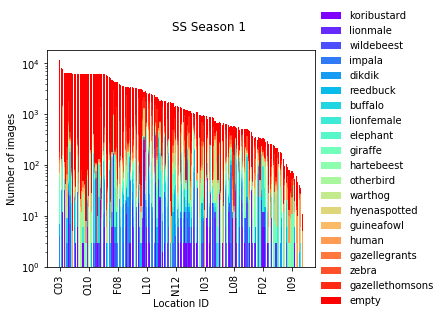

In [101]:
plot_title = 'SS Season 1'

fig = show_species_dist(ss_file_template, plot_title=plot_title, ordered_species_list=top_20, log_scale=True)